In [1]:
import os
import random
import warnings

import matplotlib.pyplot as plt
import simplstyles
import numpy as np
import pandas as pd
import seaborn as sns
from himalaya.backend import set_backend

from compare_variance_residual.residual import residual_method
from compare_variance_residual.simulation import generate_dataset
from compare_variance_residual.variance_partitioning import variance_partitioning

In [2]:
def get_path(alphas, cv, n_targets):
    path = os.path.join("results", f"targets={n_targets}", f"cv={cv}",
                        f"alphas={alphas.min()},{alphas.max()},{len(alphas)}", "varying noise")
    os.makedirs(path, exist_ok=True)
    return path

In [3]:
def get_experiments(alphas, cv, n_targets):
    path = get_path(alphas, cv, n_targets)
    experiments = []
    for file in os.listdir(path):
        if file.endswith(".csv"):
            variable = file.split("_")[1].split(".csv")[0]
            # parse variable
            noise = float(variable)
            experiments.append(noise)
    return experiments

In [4]:
def save_scores(noise_levels, d_list, scalars, n_targets, n_samples, cv, alphas):
    path = get_path(alphas, cv, n_targets)
    for noise_target in noise_levels:
        print(noise_target)
        csv_path = os.path.join(path, f"scores_{noise_target}.csv")
        scores = pd.DataFrame()
        if os.path.exists(csv_path):
            print("skipping, already exists")
            continue
        Xs, Y = generate_dataset(d_list, scalars, n_targets, n_samples, noise_target)
        print("data generated")
        x1_score, x2_score, joint_score, x1_and_x2_score, vp_x1_unique_score, vp_x2_unique_score = variance_partitioning(
            Xs, Y, n_samples_train, alphas, cv)
        print("variance partitioning done")

        scores["x1_score"] = x1_score
        scores["x2_score"] = x2_score
        scores["vp_joint_score"] = joint_score
        scores["vp_shared_score"] = x1_and_x2_score
        scores["vp_x1_unique_score"] = vp_x1_unique_score
        scores["vp_x2_unique_score"] = vp_x2_unique_score
        del x1_score, x2_score, joint_score, x1_and_x2_score, vp_x1_unique_score, vp_x2_unique_score
        print(scores.head())

        _, _, x2_to_x1_score, x1_to_x2_score, rm_x1_unique_score, rm_x2_unique_score = residual_method(
            Xs, Y, n_samples_train, alphas, cv)
        print("residual method done")
        scores["rm_x2_to_x1_score"] = np.concatenate(
            [x2_to_x1_score, np.full(len(rm_x1_unique_score) - len(x2_to_x1_score), np.nan)])
        scores["rm_x1_to_x2_score"] = np.concatenate(
            [x1_to_x2_score, np.full(len(rm_x1_unique_score) - len(x1_to_x2_score), np.nan)])
        scores["rm_x1_unique_score"] = rm_x1_unique_score
        scores["rm_x2_unique_score"] = rm_x2_unique_score
        del x2_to_x1_score, x1_to_x2_score, rm_x1_unique_score, rm_x2_unique_score
        del Xs, Y
        scores.to_csv(csv_path, index=False)

# Save scores for varying noise levels

In [5]:
backend = set_backend("cupy", on_error="warn")
warnings.filterwarnings("ignore")
random.seed(42)
plt.style.use('nord-light-talk')

In [6]:
d_list = [100, 100, 100]
n_targets = 10000
n_samples_train = 10000
n_samples_test = 100
n_samples = n_samples_train + n_samples_test
scalars = [1 / 3, 1 / 3, 1 / 3]

cv = 10
alphas = np.logspace(-5, 5, 10)

In [9]:
nstep = 11
noise_levels = np.linspace(0, 1, nstep)
noise_levels

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [ ]:
save_scores(noise_levels, d_list, scalars, n_targets, n_samples, cv, alphas)

0.0
skipping, already exists
0.1
skipping, already exists
0.2
skipping, already exists
0.30000000000000004


# Plot scores

In [17]:
vp = pd.DataFrame()
rm = pd.DataFrame()

all_levels = get_experiments(alphas, cv, n_targets)
print(all_levels)
for i, noise_level in enumerate(all_levels):
    scores = pd.read_csv(os.path.join(get_path(alphas, cv, n_targets), f"scores_{noise_level}.csv"))
    vp_x1_unique_predicted = scores['vp_x1_unique_score']
    vp_scores = pd.DataFrame({
        'noise_target': [noise_level] * len(vp_x1_unique_predicted),
        'vp_x1_unique_score': vp_x1_unique_predicted,
    }, index=range(len(vp_x1_unique_predicted)))

    rm_x1_unique_score = scores['rm_x1_unique_score']
    rm_scores = pd.DataFrame({
        'noise_target': [noise_level] * len(vp_x1_unique_predicted),
        'rm_x1_unique_score': rm_x1_unique_score,
    }, index=range(len(vp_x1_unique_predicted)))

    vp = pd.concat([vp, vp_scores], ignore_index=True)
    rm = pd.concat([rm, rm_scores], ignore_index=True)
vp.head()

[0.0, 0.005336699231206307, 0.001, 0.3511191734215127, 0.001873817422860383, 0.12328467394420659, 2.848035868435799e-05, 1e-05, 0.04328761281083057, 1.0, 0.01519911082952933, 0.1, 0.01, 0.0001, 8.111308307896872e-05, 0.0002310129700083158, 0.0006579332246575682]


,noise_target,vp_x1_unique_score
0,0.0,0.351996
1,0.0,0.334528
2,0.0,0.270543
3,0.0,0.323304
4,0.0,0.438242


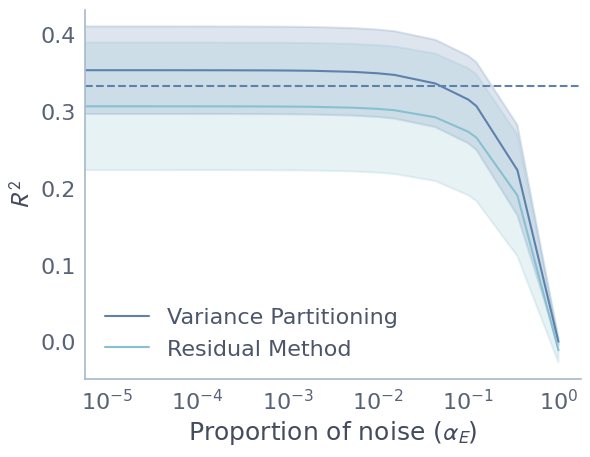

In [18]:
sns.lineplot(data=vp, x='noise_target', y='vp_x1_unique_score', label='Variance Partitioning', errorbar='sd')
sns.lineplot(data=rm, x='noise_target', y='rm_x1_unique_score', label='Residual Method', errorbar='sd')
plt.axhline(scalars[1], linestyle='--', label='true unique variance')
plt.xlabel(r"Proportion of noise ($\alpha_E$)")
plt.ylabel(r"$R^2$")
plt.xscale('log')